# Lab 1

## Question 1

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import statsmodels.api as sm
import powerlaw
import scipy.stats as stats

### Dataset

Perform general statistical analyses on the datasets.  Are the results expected ?Perform some sanity checks on the data.  Is the dataset free of visible problems ?

In [133]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

In [134]:
files = get_all_files(os.path.join('data', 'SG'))

dfs = []

for file in files:
    df_small = pd.read_csv(os.path.join('data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    break                   # < ----------------- remove this line to read all files
df = pd.concat(dfs)
df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
df.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445


- A: add limit order
- T: Trade (takes the best price)
- M: Modification
- C: Cancel

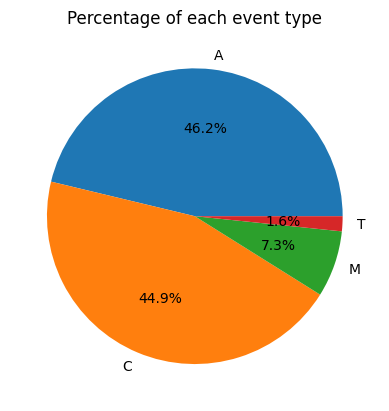

In [135]:
plt.title("Percentage of each event type")
plt.pie(df['etype'].value_counts() / len(df), labels=df['etype'].value_counts().index, autopct='%1.1f%%')
plt.show()

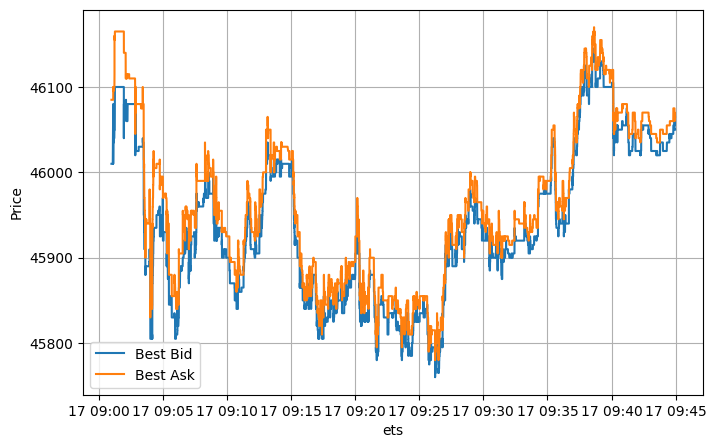

In [136]:
df_2 = df.copy()
df_2.set_index('ets', inplace=True)
df_2.sort_index(inplace=True, ascending=True)

start_date = '2017-01-17 09:01:00.270164'
end_date = '2017-01-17 09:45:00.00'

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_2[start_date:end_date], x='ets', y='bp0', label="Best Bid")
sns.lineplot(data=df_2[start_date:end_date], x='ets', y='ap0', label="Best Ask")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#### Trade Volumes

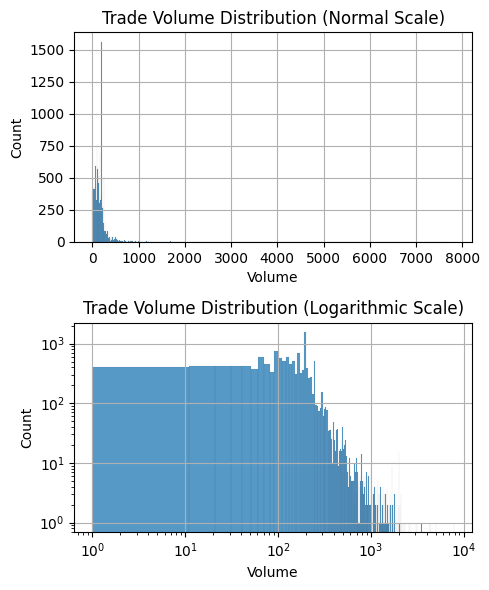

In [147]:
# Filter the DataFrame for trades
df_trades = df[df['etype'] == 'T'].copy()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

# Normal scale plot
sns.histplot(df_trades, x='eqty', kde=False, ax=axes[0])
axes[0].set_title('Trade Volume Distribution (Normal Scale)')
axes[0].set_xlabel('Volume')
axes[0].grid()

# Logarithmic scale plot
sns.histplot(df_trades, x='eqty', kde=False, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Volume')
axes[1].set_title('Trade Volume Distribution (Logarithmic Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

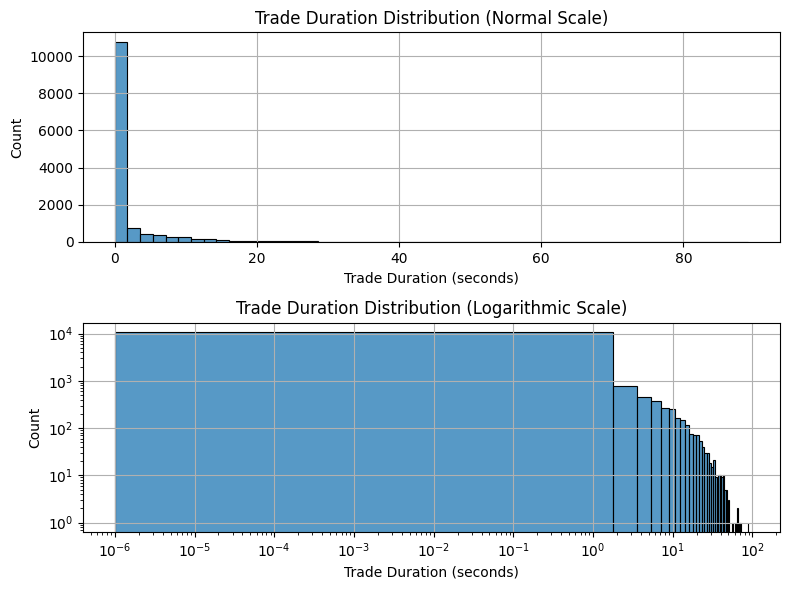

In [148]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades['trade_duration'] = df_trades['ets'].diff().dt.total_seconds()
df_trades = df_trades.iloc[1:]

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(df_trades, x='trade_duration', kde=False, bins=50, ax=axes[0])
axes[0].set_title('Trade Duration Distribution (Normal Scale)')
axes[0].set_xlabel('Trade Duration (seconds)')
axes[0].grid()

sns.histplot(df_trades, x='trade_duration', kde=False, bins=50, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Trade Duration (seconds)')
axes[1].set_title('Trade Duration Distribution (Logarithmic Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency (log scale)')

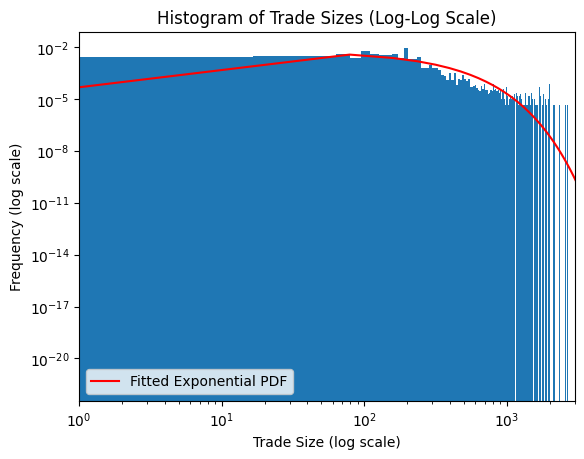

In [149]:
# Fit an exponential distribution to the data
loc, scale = stats.expon.fit(df_trades['eqty'])

# Create a finer grid for plotting the fitted PDF
x_fit = np.linspace(0, np.max(df_trades['eqty']), 100)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)

# Plot the original data and the fitted PDF
plt.hist(df_trades["eqty"], bins=500, density=True)
plt.plot(x_fit, y_fit, 'r-', label='Fitted Exponential PDF')
plt.legend()
plt.xlim(1, 3000)
plt.xscale('log')
plt.yscale('log')
plt.title('Histogram of Trade Sizes (Log-Log Scale)')
plt.xlabel('Trade Size (log scale)')
plt.ylabel('Frequency (log scale)')

Calculating best minimal value for power law fit


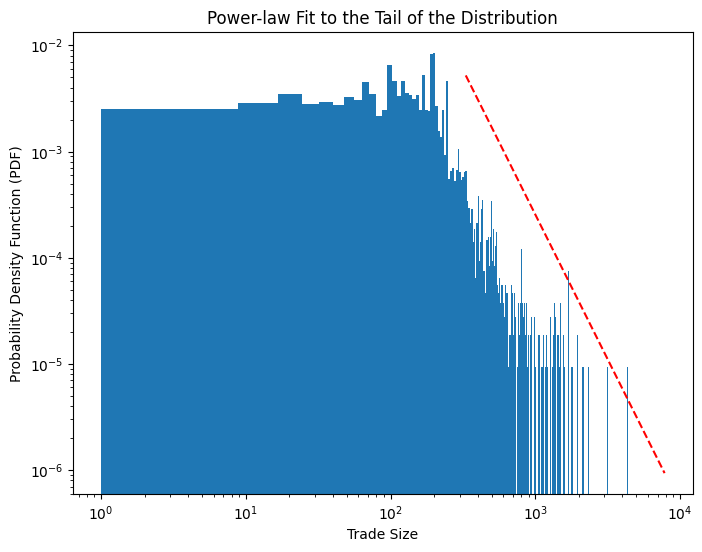

Power-law alpha: 2.728016118460718
Power-law xmin: 331.0


In [150]:
# Use the powerlaw package to fit the data
fit = powerlaw.Fit(df_trades["eqty"])

plt.figure(figsize=(8, 6))

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
plt.hist(df_trades["eqty"], bins=1000, density=True)
fit.power_law.plot_pdf(color='r', linestyle='--')

plt.xlabel('Trade Size')
plt.ylabel('Probability Density Function (PDF)')
plt.title('Power-law Fit to the Tail of the Distribution')
plt.show()

# Print the estimated parameters
print(f"Power-law alpha: {alpha}")
print(f"Power-law xmin: {xmin}")

#### Trading activity and volatility

### Mid-Price and Weighted Mid-Price Visualization

The mid-price is defined as :

$$Mid\text{-}Price = \frac{a(t) + b(t)}{2}$$

The **weighted mid-price** is defined as:

$$W_{mid-price} = \frac{a(t)q^B(t) + b(t)q^A(t)}{q^B(t) + q^A(t)}$$

In [63]:
# bp0, bq0,	ap0, aq0
# best bid price, best bid quantity, best ask price, best ask quantity

df['mid_price'] = (df['bp0'] + df['ap0']) / 2

df['weighted_mid_price'] = ((df['bp0'] * df['aq0']) + (df['ap0'] * df['bq0'])) / (df['bq0'] + df['aq0'])

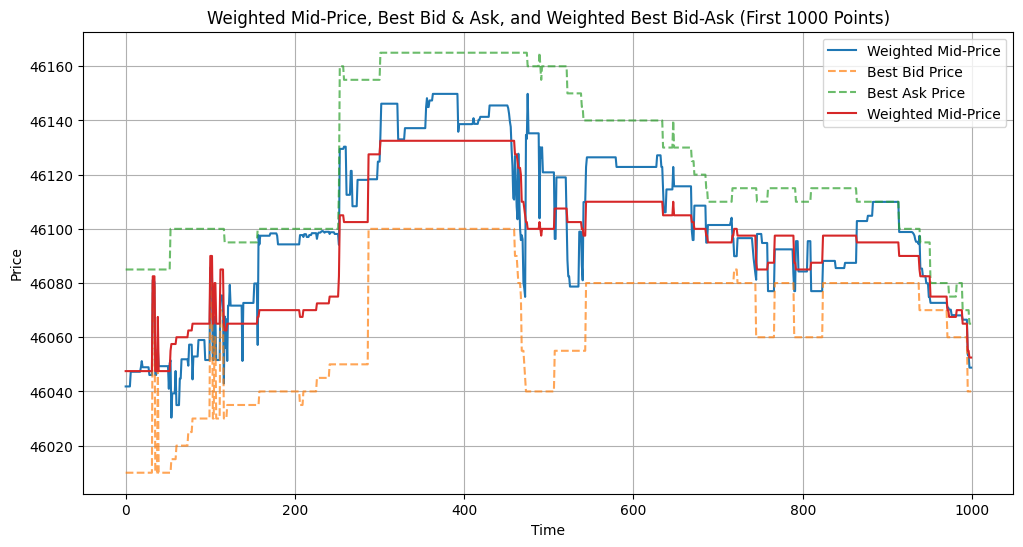

In [67]:
df_subset = df.iloc[:1000]

plt.figure(figsize=(12, 6))
df_subset['weighted_mid_price'].plot(label="Weighted Mid-Price", linestyle='-', linewidth=1.5)
df_subset['bp0'].plot(label="Best Bid Price", linestyle='--', alpha=0.7)
df_subset['ap0'].plot(label="Best Ask Price", linestyle='--', alpha=0.7)
df_subset['mid_price'].plot(label="Weighted Mid-Price", linestyle='-', linewidth=1.5)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Weighted Mid-Price, Best Bid & Ask, and Weighted Best Bid-Ask (First 1000 Points)")
plt.legend()
plt.grid(True)
plt.show()

In [153]:
df['tick_size_bid'] = df['bp0'].diff().abs()
df['tick_size_ask'] = df['ap0'].diff().abs()

tick_sizes = pd.concat([df['tick_size_bid'], df['tick_size_ask']]).replace(0, np.nan).dropna()

measured_tick_size = tick_sizes.min()
print(f'the smallest tick size occuring on the dataset is in line with the official tick size : 
      {measured_tick_size} for stocks between 9.99 and 50 Euros as outlined in the course')

the smallest tick size occuring on the dataset is in line with the official tick size : 5.0 for stocks between 9.99 and 50 Euros as outlined in the course


np.float64(5.0)